In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4";


%load_ext autoreload
%autoreload 2
from CW import CW
from FGSM import FGSM
from OPT_attack import OPT_attack
from OPT_attack_polar import OPT_attack_polar
from OPT_attack_polar_GD import OPT_attack_polar_GD
from OPT_attack_lsq import OPT_attack_lsq
from OPT_attack_polar_lsq import OPT_attack_polar_lsq
from OPT_attack_GD import OPT_attack_GD
from OPT_genattack import OPT_genattack
from OPT_attack_sign_SGD import OPT_attack_sign_SGD
from OPT_attack_sign_SGD_lf import OPT_attack_sign_SGD_lf
from ZOO import ZOO
from OPT_attack_lf import OPT_attack_lf
from nes_attack import NES
from models import PytorchModel
import torch
from allmodels import MNIST, load_model, load_mnist_data, load_cifar10_data, CIFAR10
import os
import numpy as np
import matplotlib.pyplot as plt

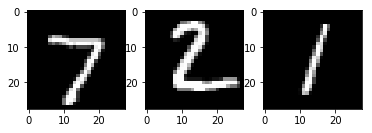

In [2]:
net = MNIST()
net.cuda()
net = torch.nn.DataParallel(net, device_ids=[0])
# print(net)
load_model(net,'mnist_gpu.pt')
net.eval()
model = net.module if torch.cuda.is_available() else net
# model = model.cpu()
train_loader, test_loader, train_dataset, test_dataset = load_mnist_data()

X0, Y0 = None, None
X1, Y1 = None, None
X2, Y2 = None, None
for i, (xi,yi) in enumerate(test_loader):
    if i==0:
        X0, Y0 = xi, yi
    if i==1:
        X1, Y1 = xi, yi
    if i==2:
        X2, Y2 = xi, yi
    if i==10:
        break
        
amodel = PytorchModel(model, bounds=[0,1], num_classes=10)

def plot_adv(X, adv):
    plt.subplot(1,2,1)
    plt.imshow(X[0][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(adv.cpu()[0][0], cmap='gray')
    plt.show()

# Plot the sample images
plt.subplot(1,3,1)
plt.imshow(X0[0][0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(X1[0][0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(X2[0][0], cmap='gray')
plt.show()

### Baseline distortions for 3 examples (Original Randomized Gradient Free optimization)

In [3]:
# These distortions were calculated by taking average of 10 trials for each example
# using the randomized gradient free method.
d0 = (1.5292 + 1.5095 + 1.4743 + 1.3108 + 1.2816 + 1.4416 + 1.5323 + 1.3404 + 1.3365 + 1.3819)/10
d1 = (1.2531 + 1.3640 + 1.2929 + 1.2826 + 1.2985 + 1.3726 + 1.3016 + 1.2917 + 1.2976 + 1.2911)/10
d2 = (0.7499 + 0.7520 + 0.7615 + 0.7599 + 0.7609 + 0.7635 + 0.7450 + 0.7497 + 0.8018 + 0.7475)/10
print("d0 ", d0)
print("d1 ", d1)
print("d3 ", d2)

d0  1.41381
d1  1.30457
d3  0.7591699999999999


In [9]:
x, y = X2, Y2
target = 4
seed = 100

### Untargeted

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Searching for the initial direction on 100 random directions: 
--------> Found distortion 1.2253
--------> Found distortion 1.1832
--------> Found distortion 1.0333
--------> Found distortion 0.9936
--------> Found distortion 0.9862
--------> Found distortion 0.9370
--------> Found distortion 0.8480
--------> Found distortion 0.8322
--------> Found distortion 0.8046
==========> Found best distortion 0.8046 in 0.8304 seconds using 346 queries
Iteration  10 distortion 0.627034 num_queries 1345
Iteration  20 distortion 0.587195 num_queries 2701
Iteration  30 distortion 0.574141 num_queries 3998
Iteration  40 distortion 0.553978 num_queries 5821
Iteration  50 distortion 0.538684 num_queries 7588
Iteration  60 distortion 0.523825 num_queries 9257
Iteration  70 distortion 0.513147 num_queries 11534
Iteration  80 distortion 0.505613 num_queries 13748
Iteration  90 distortion 0.497917 num_queries 15867
Iteration 100 distortion 0.482077 num_queries 17985
Iteration 110 distortion 0.467717 num_qu

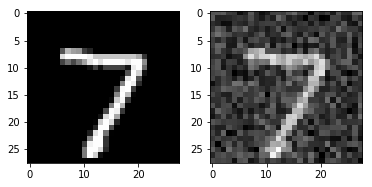

In [6]:
attack = OPT_attack_lf(amodel)
adv, dist = attack(x.cuda(), y.cuda(), seed=seed)
plot_adv(x, adv)

Searching for the initial direction on 100 random directions: 
--------> Found distortion 0.6939
--------> Found distortion 0.5061
--------> Found distortion 0.4640
--------> Found distortion 0.4435
--------> Found distortion 0.4374
--------> Found distortion 0.4216
--------> Found distortion 0.4215
==========> Found best distortion 0.4215 in 0.4201 seconds using 309 queries
Iteration   1 distortion 0.354331 num_queries 670
Iteration   6 distortion 0.267247 num_queries 2146
Iteration  11 distortion 0.215276 num_queries 3634
Iteration  16 distortion 0.195438 num_queries 4844
Iteration  21 distortion 0.190117 num_queries 5987
Iteration  26 distortion 0.178301 num_queries 7255
Iteration  31 distortion 0.174755 num_queries 8378
Iteration  36 distortion 0.169393 num_queries 9506
Iteration  41 distortion 0.167277 num_queries 10732
Iteration  46 distortion 0.165444 num_queries 11853
Iteration  51 distortion 0.163576 num_queries 12985
Iteration  56 distortion 0.161722 num_queries 14196
Iterati

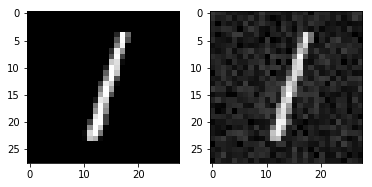

In [10]:
attack = OPT_attack_sign_SGD_lf(amodel)
adv_sign, dist_sign = attack(x.cuda(), y.cuda(), seed=seed)
plot_adv(x, adv_sign)

Searching for the initial direction on 100 random directions: 
--------> Found distortion 0.6939
--------> Found distortion 0.5061
--------> Found distortion 0.4640
--------> Found distortion 0.4435
--------> Found distortion 0.4374
--------> Found distortion 0.4216
--------> Found distortion 0.4215
==========> Found best distortion 0.4215 in 0.4212 seconds using 309 queries
Iteration   1 distortion 0.353292 num_queries 640
Iteration   6 distortion 0.268287 num_queries 1977
Iteration  11 distortion 0.210755 num_queries 3448
Iteration  16 distortion 0.200016 num_queries 4676
Iteration  21 distortion 0.192009 num_queries 5887
Iteration  26 distortion 0.188461 num_queries 7056
Iteration  31 distortion 0.186167 num_queries 8184
Iteration  36 distortion 0.181588 num_queries 9317
Iteration  41 distortion 0.178544 num_queries 10498
Iteration  46 distortion 0.176415 num_queries 11667
Iteration  51 distortion 0.174605 num_queries 12803
Iteration  56 distortion 0.173092 num_queries 13981
Iterati

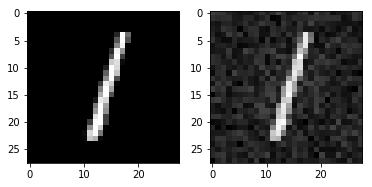

In [11]:
attack = OPT_attack_sign_SGD_lf(amodel)
adv_sign, dist_sign = attack(x.cuda(), y.cuda(), seed=seed)
plot_adv(x, adv_sign)

### Targeted

Targeted attack - Source: 7 and Target: 4 Seed: 100
Searching for the initial direction on 100 samples: 
--------> Found distortion 0.6148
--------> Found distortion 0.5575
--------> Found distortion 0.5474


/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


--------> Found distortion 0.5291
--------> Found distortion 0.4489
--------> Found distortion 0.4482
--------> Found distortion 0.4243
==========> Found best distortion 0.4243 in 2.0079 seconds using 1152 queries
Iteration  10 distortion 0.422449 num_queries 2886
Iteration  20 distortion 0.421833 num_queries 6538
Iteration  30 distortion 0.421652 num_queries 10797
Iteration  40 distortion 0.421570 num_queries 15300
Iteration  50 distortion 0.421553 num_queries 20346
Iteration  60 distortion 0.421547 num_queries 25710
Iteration  70 distortion 0.421544 num_queries 31253

Adversarial Example Found Successfully: distortion 0.4215 target 4 queries 35737 
Time: 55.3961 seconds


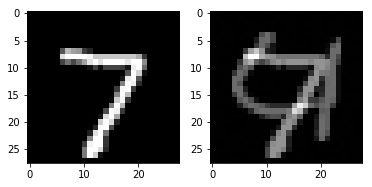

In [10]:
attack = OPT_attack_lf(amodel, train_dataset=train_dataset)
adv, dist = attack(x.cuda(), y.cuda(), target=target*torch.ones(1, dtype=torch.long).cuda(), seed=seed)
plot_adv(x, adv)

Targeted attack - Source: 7 and Target: 4 Seed: 100
Searching for the initial direction on 100 samples: 
--------> Found distortion 0.6148
--------> Found distortion 0.5575
--------> Found distortion 0.5474
--------> Found distortion 0.5291


/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


--------> Found distortion 0.4489
--------> Found distortion 0.4482
--------> Found distortion 0.4243
==========> Found best distortion 0.4243 in 1.7001 seconds using 1152 queries
Iteration   1 distortion 0.422861 num_queries 1378
Iteration   6 distortion 0.422446 num_queries 2573
Iteration  11 distortion 0.422313 num_queries 3716
Iteration  16 distortion 0.421982 num_queries 4911
Iteration  21 distortion 0.421769 num_queries 6080
Iteration  26 distortion 0.421656 num_queries 7223
Iteration  31 distortion 0.421521 num_queries 8379
Iteration  36 distortion 0.421200 num_queries 9587
Iteration  41 distortion 0.420838 num_queries 10795
Iteration  46 distortion 0.420618 num_queries 11951
Iteration  51 distortion 0.420477 num_queries 13094
Iteration  56 distortion 0.420283 num_queries 14263
Iteration  61 distortion 0.420158 num_queries 15406
Iteration  66 distortion 0.420051 num_queries 16562
Iteration  71 distortion 0.420021 num_queries 17938
Iteration  76 distortion 0.419973 num_queries 19

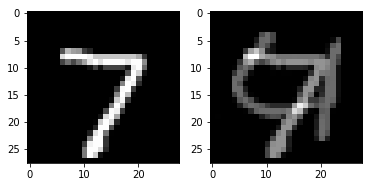

In [11]:
attack = OPT_attack_sign_SGD_lf(amodel, train_dataset=train_dataset)
adv, dist = attack(x.cuda(), y.cuda(), target=target*torch.ones(1, dtype=torch.long).cuda(), seed=seed)
plot_adv(x, adv)

Targeted attack - Source: 7 and Target: 4 Seed: 100
Searching for the initial direction on 100 samples: 
--------> Found distortion 0.6148
--------> Found distortion 0.5575
--------> Found distortion 0.5474
--------> Found distortion 0.5291


/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


--------> Found distortion 0.4489
--------> Found distortion 0.4482
--------> Found distortion 0.4243
==========> Found best distortion 0.4243 in 1.6093 seconds using 1152 queries
Iteration   1 distortion 0.423011 num_queries 1443
Iteration   6 distortion 0.422521 num_queries 2612
Iteration  11 distortion 0.421841 num_queries 3781
Iteration  16 distortion 0.421436 num_queries 5242
Iteration  21 distortion 0.421313 num_queries 7128
Iteration  26 distortion 0.421170 num_queries 8356
Iteration  31 distortion 0.420908 num_queries 9584
Iteration  36 distortion 0.420778 num_queries 11612
Iteration  41 distortion 0.420757 num_queries 14468

Adversarial Example Found Successfully: distortion 0.4208 target 4 queries 14468 LS queries 5116 
Time: 22.1666 seconds


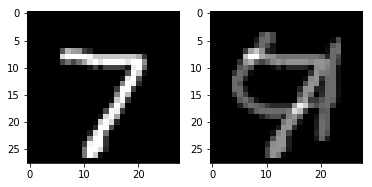

In [12]:
attack = OPT_attack_sign_SGD_lf(amodel, train_dataset=train_dataset)
adv, dist = attack(x.cuda(), y.cuda(), target=target*torch.ones(1, dtype=torch.long).cuda(), seed=seed, svm=True)
plot_adv(x, adv)